In [24]:
import numpy as np
import pandas as pd
 
# Constants
NUM_ACS = 37748  # Number of ACs
NUM_SESSIONS = 842967  # Total number of sessions (based on the processed HST)
 
# Possible values for categorical features
MODES = ['Cool', 'Dry', 'Auto', 'Clean']
WIND_SPEEDS = [1, 2, 3, 4]
VENTS = [1, 2, 3]
CAPACITIES = [1.0, 1.5, 2.0, 2.5, 3.0]  # in tons
 
# Generate AC IDs
ac_ids = np.random.randint(1, NUM_ACS + 1, NUM_SESSIONS)
 
# Generate timestamps
timestamps = pd.date_range(start='2022-05-01', periods=NUM_SESSIONS, freq='H')
 
# Generate continuous features
external_temperatures = np.random.randint(30, 45, NUM_SESSIONS)  # in Celsius, realistic summer temperatures
external_humidities = np.random.randint(30, 70, NUM_SESSIONS)  # in percentage
 
# Generate internal temperatures and desired temperatures with realistic constraints
current_temperatures = np.random.randint(26, 30, NUM_SESSIONS)  # in Celsius, realistic indoor temperatures
desired_temperatures = current_temperatures - np.random.randint(1, 10, NUM_SESSIONS)  # Desired temp lower than current
 
# Generate internal humidities based on the external humidity with some added randomness
internal_humidities = external_humidities - np.random.uniform(5, 15, NUM_SESSIONS)
 
# Generate categorical features
wind_speeds = np.random.choice(WIND_SPEEDS, NUM_SESSIONS)
num_vents = np.random.choice(VENTS, NUM_SESSIONS)
modes = np.random.choice(MODES, NUM_SESSIONS)
hours = np.random.choice(range(24), NUM_SESSIONS)
capacities = np.random.choice(CAPACITIES, NUM_SESSIONS)
 
# Generate cooling times based on a more realistic function
cooling_times = np.maximum(300, (desired_temperatures - current_temperatures) * 100 + wind_speeds * 50 + capacities * 200 + np.random.normal(0, 50, NUM_SESSIONS)).astype(int)
 
# Generate energy consumption based on mode, wind speed, and cooling time
mode_energy_factor = {
    'Cool': 1.0,
    'Dry': 0.8,
    'Auto': 0.7,
    'Clean': 1.2 
}
 
energy_consumptions = (cooling_times / 3600) * np.array([mode_energy_factor[mode] for mode in modes]) * capacities * wind_speeds
 
# Create DataFrame
data = {
    'AC_ID': ac_ids,
    'Timestamp': timestamps,
    'Current_Temperature': current_temperatures,
    'Desired_Temperature': desired_temperatures,
    'Internal_Humidity': internal_humidities,
    'External_Temperature': external_temperatures,
    'External_Humidity': external_humidities,
    'Wind_Speed': wind_speeds,
    'Number_of_Vents': num_vents,
    'Mode': modes,
    'Hour_of_Day': hours,
    'Capacity': capacities,
    'Energy_Consumption': energy_consumptions,
    'Cooling_Time': cooling_times
}
 
df = pd.DataFrame(data)
 
# Display the first few rows of the dataframe
print(df.head()) 

   AC_ID           Timestamp  Current_Temperature  Desired_Temperature  \
0  30239 2022-05-01 00:00:00                   26                   21   
1  37306 2022-05-01 01:00:00                   29                   27   
2  21828 2022-05-01 02:00:00                   29                   28   
3  24402 2022-05-01 03:00:00                   29                   20   
4   9141 2022-05-01 04:00:00                   29                   25   

   Internal_Humidity  External_Temperature  External_Humidity  Wind_Speed  \
0          26.779740                    42                 34           3   
1          42.248628                    36                 50           3   
2          54.428313                    35                 67           4   
3          41.090043                    30                 52           4   
4          43.788993                    44                 57           1   

   Number_of_Vents   Mode  Hour_of_Day  Capacity  Energy_Consumption  \
0                3  

In [25]:
df.to_csv(r'C:/downloads/simulated_ac_data.csv', index=False)

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
 
df = pd.read_csv(r'C:/downloads/simulated_ac_data.csv')
 
def preprocess_data(df):
 
    feature_columns = [
        'Hour_of_Day', 'Mode', 'Wind_Speed', 'Number_of_Vents', 'Current_Temperature',
        'Desired_Temperature', 'External_Temperature', 'External_Humidity', 'Capacity'
    ]
    target_column = 'Energy_Consumption'
 
    X = df[feature_columns]
    y = df[target_column]
 
    numeric_features = ['Hour_of_Day', 'Wind_Speed', 'Number_of_Vents', 'Current_Temperature',
                        'Desired_Temperature', 'External_Temperature', 'External_Humidity', 'Capacity']
    categorical_features = ['Mode']
 
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
 
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    return X_train, X_test, y_train, y_test, preprocessor
 
X_train, X_test, y_train, y_test, preprocessor = preprocess_data(df)

In [27]:
# Define the DNN model
import tensorflow as tf
def create_dnn_model(input_shape):
    model = Sequential()
    model.add(Dense(15, input_dim=input_shape, activation='relu'))
    for _ in range(1):  
        model.add(Dense(14, activation='relu'))
    for _ in range(2):
        model.add(Dense(8, activation='relu'))
    for _ in range(1):  
        model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='relu'))  
    model.compile(optimizer=Adam(), loss = tf.keras.losses.Huber(), metrics=['mae'])
    return model
 
input_shape = X_train.shape[1]
model = create_dnn_model(input_shape)
model.fit(X_train, y_train, batch_size = 500, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
1349/1349 [==============================] - 5s 3ms/step - loss: 0.0063 - mae: 0.0619 - val_loss: 0.0016 - val_mae: 0.0359
Epoch 2/20
1349/1349 [==============================] - 3s 2ms/step - loss: 0.0013 - mae: 0.0287 - val_loss: 0.0011 - val_mae: 0.0251
Epoch 3/20
1349/1349 [==============================] - 3s 2ms/step - loss: 0.0011 - mae: 0.0237 - val_loss: 0.0011 - val_mae: 0.0233
Epoch 4/20
1349/1349 [==============================] - 3s 2ms/step - loss: 0.0011 - mae: 0.0219 - val_loss: 0.0010 - val_mae: 0.0212
Epoch 5/20
1349/1349 [==============================] - 3s 2ms/step - loss: 0.0010 - mae: 0.0209 - val_loss: 9.9776e-04 - val_mae: 0.0196
Epoch 6/20
1349/1349 [==============================] - 3s 2ms/step - loss: 0.0010 - mae: 0.0204 - val_loss: 0.0011 - val_mae: 0.0227
Epoch 7/20
1349/1349 [==============================] - 3s 2ms/step - loss: 0.0010 - mae: 0.0199 - val_loss: 0.0010 - val_mae: 0.0187
Epoch 8/20
1349/1349 [==============================] - 3s

In [28]:
# Save
model.save('dnn_model_3.h5')
 

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [35]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

# Load the saved model
model = load_model('dnn_model_3.h5')

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R²): {r2}')

5269/5269 [==============================] - 7s 1ms/step
Mean Absolute Error (MAE): 0.018956615677261295
Mean Squared Error (MSE): 0.0019708526942953807
R-squared (R²): 0.9850715925534893


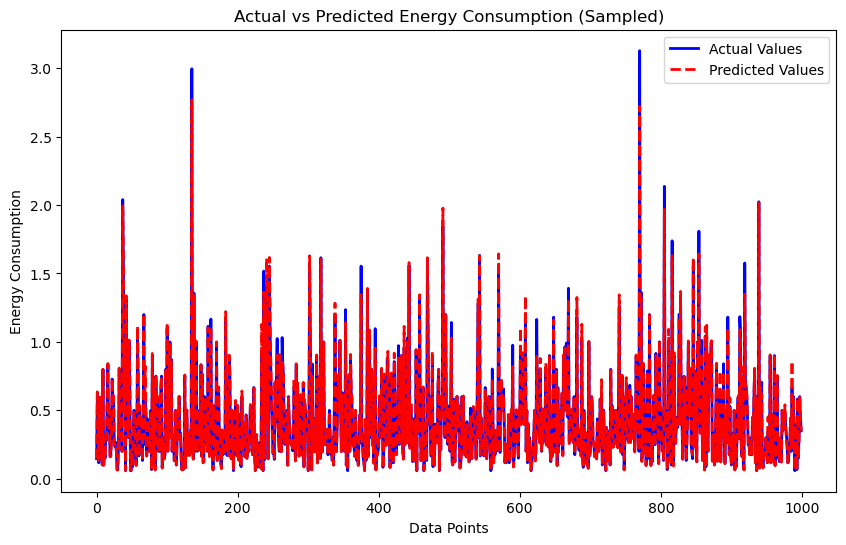

In [36]:
import matplotlib.pyplot as plt
 
 
# Sample a subset of data points
sample_size = 1000  # Adjust this number based on your preference
indices = np.random.choice(range(len(y_test)), sample_size)
y_test_sample = y_test.iloc[indices]
y_pred_sample = y_pred[indices]
 
# Plot the sampled actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_sample.values, label='Actual Values', color='blue', linewidth=2)
plt.plot(y_pred_sample, label='Predicted Values', color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Data Points')
plt.ylabel('Energy Consumption')
plt.title('Actual vs Predicted Energy Consumption (Sampled)')
plt.legend()
plt.show()

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import load_model
from gower import gower_matrix

# Load the predictive model
model = load_model('dnn_model_3.h5')

# Load and preprocess new data for generating recommendations
df = pd.read_csv(r'C:\Downloads\simulated_ac_data.csv')  # Data for prediction

# Define feature columns and target column
feature_columns = [
    'Hour_of_Day', 'Mode', 'Wind_Speed', 'Number_of_Vents', 'Current_Temperature',
    'Desired_Temperature', 'External_Temperature', 'External_Humidity', 'Capacity'
]
target_column = 'Energy_Consumption'

# Create a preprocessor for the data
numeric_features = ['Hour_of_Day', 'Wind_Speed', 'Number_of_Vents', 'Current_Temperature',
                    'Desired_Temperature', 'External_Temperature', 'External_Humidity', 'Capacity']
categorical_features = ['Mode']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit the preprocessor on the entire dataset
preprocessor.fit(df[feature_columns])

# Preprocess the new data
def preprocess_new_data(df, preprocessor):
    X_new = df[feature_columns]
    X_new = preprocessor.transform(X_new)
    return X_new, df

def recommend_settings(ac_id, current_settings, model, preprocessor, df, top_k=5):
    # Filter data for the specific AC
    ac_data = df[df['AC_ID'] == ac_id]
   
    # Extract relevant columns for recommendation
    feature_columns = [
        'Hour_of_Day', 'Mode', 'Wind_Speed', 'Number_of_Vents', 'Current_Temperature',
        'Desired_Temperature', 'External_Temperature', 'External_Humidity', 'Capacity'
    ]
    target_column = 'Energy_Consumption'
 
    # Preprocess the current settings
    def preprocess_single(current_settings, preprocessor):
        df_single = pd.DataFrame([current_settings], columns=feature_columns)
        return preprocessor.transform(df_single)
 
    # Predict energy consumption for current settings
    current_features = preprocess_single(current_settings, preprocessor)    
    current_energy = model.predict(current_features)[0][0]
 
    # Generate possible alternate settings
    def generate_alternate_settings(current_settings, df, num_samples=1000000):
        num_samples = min(num_samples, len(df))  # Ensure we do not sample more than available rows
        similar_ac_data = df.sample(num_samples)
        return similar_ac_data
 
    # Generate alternate settings
    alternate_settings = generate_alternate_settings(current_settings, ac_data)
 
    # Predict energy consumption for each alternate setting
    alternate_settings['Predicted_Energy'] = alternate_settings.apply(
        lambda row: model.predict(preprocess_single(row[feature_columns].to_dict(), preprocessor))[0][0],
        axis=1
    )
 
    # Compute Gower's similarity coefficient
    def gower_similarity(current_settings, alternate_settings, feature_columns):
        current_df = pd.DataFrame([current_settings], columns=feature_columns)
        similarities = gower_matrix(current_df, alternate_settings[feature_columns])
        return similarities.flatten()
 
    # Define feature weights for similarity calculation
    feature_weights = {
        'Desired_Temperature': 0.9,
        'Wind_Speed': 0.2,
        'Number_of_Vents': 0.2,
        'Capacity': 0.2
    }
 
    # Calculate similarities
    alternate_settings['Similarity'] = gower_similarity(current_settings, alternate_settings, feature_columns)
 
    # Filter top-k recommendations
    top_recommendations = alternate_settings.nsmallest(top_k, 'Predicted_Energy')
 
    # Display top-k recommendations
    print("Current Settings: ", current_settings)
    print("Predicted Energy Consumption: ", current_energy)
    print("Top-k Alternate Settings:")
    recommendations = top_recommendations[['Desired_Temperature', 'Mode', 'Wind_Speed', 'Number_of_Vents', 'Predicted_Energy', 'Similarity']]
    print(recommendations)
    
    return recommendations


In [43]:

# Example current settings
current_settings = {
    'Hour_of_Day': 14,
    'Mode': 'Cool',
    'Wind_Speed': 2,
    'Number_of_Vents': 3,
    'Current_Temperature': 30,
    'Desired_Temperature': 24,
    'External_Temperature': 35,
    'External_Humidity': 50,
    'Capacity': 1.5
}

# Example AC_ID
ac_id = 1
# Call the function with the provided settings and save recommendations
recommendations = recommend_settings(ac_id, current_settings, model, preprocessor, df, top_k=5)

# Save recommendations to a CSV file to send to Arduino
recommendations.to_csv('recommendations.csv', index=False)

1/1 [==============================] - 0s 24ms/step
Current Settings:  {'Hour_of_Day': 14, 'Mode': 'Cool', 'Wind_Speed': 2, 'Number_of_Vents': 3, 'Current_Temperature': 30, 'Desired_Temperature': 24, 'External_Temperature': 35, 'External_Humidity': 50, 'Capacity': 1.5}
Predicted Energy Consumption:  0.24886295
Top-k Alternate Settings:
        Desired_Temperature   Mode  Wind_Speed  Number_of_Vents  \
98981                    25   Cool           1                1   
143788                   20    Dry           1                1   
600025                   22    Dry           1                2   
394712                   25  Clean           1                1   
158515                   25   Cool           2                3   

        Predicted_Energy  Similarity  
98981           0.124744    0.353204  
143788          0.130908    0.476108  
600025          0.200709    0.424229  
394712          0.248069    0.524583  
158515          0.259752    0.240398  


In [44]:
# Save recommendations to a CSV file to send to Arduino
recommendations.to_csv('recommendations.csv', index=False)

In [46]:
!pip install pyserial

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/90.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/90.6 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/90.6 kB ? eta -:--:--
   ------------- -------------------------- 30.7/90.6 kB 325.1 kB/s eta 0:00:01
   ------------- -------------------------- 30.7/90.6 kB 325.1 kB/s eta 0:00:01
   ------------------------------------ --- 81.9/90.6 kB 508.4 kB/s eta 0:00:01
   ---------------------------------------- 90.6/90.6 kB 467.1 kB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [66]:
import serial
import pandas as pd

# Load the recommendations
recommendations = pd.read_csv('recommendations.csv')

# Convert recommendations to a string format
recommendations_str = recommendations.to_string(index=False)

# Open serial port
ser = serial.Serial('COM4', 115200)  # Replace 'COM3' with your Arduino's serial port

# Send recommendations
ser.write(recommendations_str.encode('utf-8'))

# Close the serial port
ser.close()